<a id='top'></a>

# Data Engineering of StatsBomb WSL Data
##### Notebook to engineer JSON data available from the [StatsBomb Open Data GitHub repository](https://github.com/statsbomb/open-data)


### By [Edd Webster](https://www.twitter.com/eddwebster)
Last updated: 19/11/2020

![title](../../img/stats-bomb-logo.png)

Click [here](#section5) to jump straight to the Exploratory Data Analysis section and skip the [Task Brief](#section2), [Data Sources](#section3), and [Data Engineering](#section4) sections. Or click [here](#section6) to jump straight to the Conclusion.

___

<a id='sectionintro'></a>

## <a id='import_libraries'>Introduction</a>
This notebook engineers [FA WSL](https://womenscompetitions.thefa.com/) Event data from [StatsBomb](https://statsbomb.com/) for the 18/19, 19/20, and 20/21 seasons using [pandas](http://pandas.pydata.org/) for data manipulation through DataFrames.

For more information about this notebook and the author, I'm available through all the following channels:
*    [eddwebster.com](https://www.eddwebster.com/),
*    edd.j.webster@gmail.com,
*    [@eddwebster](https://www.twitter.com/eddwebster),
*    [LinkedIn.com/in/eddwebster](https://www.linkedin.com/in/eddwebster/),
*    [GitHub/eddwebster](https://github.com/eddwebster/),
*    [Kaggle.com/eddwebster](https://www.kaggle.com/eddwebster), and
*    [HackerRank.com/eddwebster](https://www.hackerrank.com/eddwebster).

The accompanying GitHub repository for this notebook can be found [here](https://github.com/eddwebster/fifa-league) and a static version of this notebook can be found [here](https://nbviewer.jupyter.org/github/eddwebster/fifa-league/blob/master/FIFA%2020%20Fantasy%20Football%20League%20using%20TransferMarkt%20Player%20Valuations.ipynb).

___

<a id='sectioncontents'></a>

## <a id='notebook_contents'>Notebook Contents</a>
1.    [Notebook Dependencies](#section1)<br>
2.    [Project Brief](#section2)<br>
3.    [Data Sources](#section3)<br>
      1.    [Introduction](#section3.1)<br>
      2.    [Data Dictionary](#section3.2)<br>
      3.    [Creating the DataFrame](#section3.3)<br>
      4.    [Initial Data Handling](#section3.4)<br>
      5.    [Export the Raw DataFrame](#section3.5)<br>         
4.    [Data Engineering](#section4)<br>
      1.    [Introduction](#section4.1)<br>
      2.    [Columns of Interest](#section4.2)<br>
      3.    [String Cleaning](#section4.3)<br>
      4.    [Converting Data Types](#section4.4)<br>
      5.    [Export the Engineered DataFrame](#section4.5)<br>
5.    [Exploratory Data Analysis (EDA)](#section5)<br>
      1.    [...](#section5.1)<br>
      2.    [...](#section5.2)<br>
      3.    [...](#section5.3)<br>
6.    [Summary](#section6)<br>
7.    [Next Steps](#section7)<br>
8.    [Bibliography](#section8)<br>

___

<a id='section1'></a>

## <a id='#section1'>1. Notebook Dependencies</a>

This notebook was written using [Python 3](https://docs.python.org/3.7/) and requires the following libraries:
*    [`Jupyter notebooks`](https://jupyter.org/) for this notebook environment with which this project is presented;
*    [`NumPy`](http://www.numpy.org/) for multidimensional array computing;
*    [`pandas`](http://pandas.pydata.org/) for data analysis and manipulation; and
*    [`matplotlib`](https://matplotlib.org/contents.html?v=20200411155018) for data visualisations;

All packages used for this notebook except for BeautifulSoup can be obtained by downloading and installing the [Conda](https://anaconda.org/anaconda/conda) distribution, available on all platforms (Windows, Linux and Mac OSX). Step-by-step guides on how to install Anaconda can be found for Windows [here](https://medium.com/@GalarnykMichael/install-python-on-windows-anaconda-c63c7c3d1444) and Mac [here](https://medium.com/@GalarnykMichael/install-python-on-mac-anaconda-ccd9f2014072), as well as in the Anaconda documentation itself [here](https://docs.anaconda.com/anaconda/install/).

### Import Libraries and Modules

In [2]:
# Python ≥3.5 (ideally)
import platform
import sys, getopt
assert sys.version_info >= (3, 5)
import csv

# Import Dependencies
%matplotlib inline

# Math Operations
import numpy as np
from math import pi

# Datetime
import datetime
from datetime import date
import time

# Data Preprocessing
import pandas as pd    # version 1.0.3
import os    #  used to read the csv filenames
import re
import random
from io import BytesIO
from pathlib import Path

# Reading directories
import glob
import os

# Working with JSON
import json
from pandas.io.json import json_normalize
from ast import literal_eval

# Data Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')
import missingno as msno    # visually display missing data

# Display in Jupyter
from IPython.display import Image, YouTubeVideo
from IPython.core.display import HTML

# Ignore Warnings
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

print('Setup Complete')

Setup Complete


In [3]:
# Python / module versions used here for reference
print('Python: {}'.format(platform.python_version()))
print('NumPy: {}'.format(np.__version__))
print('pandas: {}'.format(pd.__version__))
print('matplotlib: {}'.format(mpl.__version__))
print('Seaborn: {}'.format(sns.__version__))

Python: 3.7.6
NumPy: 1.18.1
pandas: 1.0.1
matplotlib: 3.1.3
Seaborn: 0.10.0


### Defined Variables

In [4]:
# Define today's date
today = datetime.datetime.now().strftime('%d/%m/%Y').replace('/', '')

### Defined Filepaths

In [5]:
# Set up initial paths to subfolders
base_dir = os.path.join('..', '..', )
data_dir = os.path.join(base_dir, 'data')
data_dir_fbref = os.path.join(base_dir, 'data', 'fbref')
data_dir_tm = os.path.join(base_dir, 'data', 'tm')
data_dir_sb = os.path.join(base_dir, 'data', 'sb')
img_dir = os.path.join(base_dir, 'img')
fig_dir = os.path.join(base_dir, 'img', 'fig')
video_dir = os.path.join(base_dir, 'video')

### Notebook Settings

In [6]:
pd.set_option('display.max_columns', None)

### Custom Functions

In [7]:
def draw_pitch(pitch, line, orientation,view):
    
    orientation = orientation
    view = view
    line = line
    pitch = pitch
    
    if orientation.lower().startswith("h"):
        
        if view.lower().startswith("h"):
            fig,ax = plt.subplots(figsize=(6.8,10.4))
            plt.xlim(49,105)
            plt.ylim(-1,69)
        else:
            fig,ax = plt.subplots(figsize=(10.4,6.8))
            plt.xlim(-1,105)
            plt.ylim(-1,69)
        ax.axis('off') # this hides the x and y ticks
    
        # side and goal lines #
        ly1 = [0,0,68,68,0]
        lx1 = [0,104,104,0,0]

        plt.plot(lx1,ly1,color=line,zorder=5)


        # boxes, 6 yard box and goals

            #outer boxes#
        ly2 = [13.84,13.84,54.16,54.16] 
        lx2 = [104,87.5,87.5,104]
        plt.plot(lx2,ly2,color=line,zorder=5)

        ly3 = [13.84,13.84,54.16,54.16] 
        lx3 = [0,16.5,16.5,0]
        plt.plot(lx3,ly3,color=line,zorder=5)

            #goals#
        ly4 = [30.34,30.34,37.66,37.66]
        lx4 = [104,104.2,104.2,104]
        plt.plot(lx4,ly4,color=line,zorder=5)

        ly5 = [30.34,30.34,37.66,37.66]
        lx5 = [0,-0.2,-0.2,0]
        plt.plot(lx5,ly5,color=line,zorder=5)


           #6 yard boxes#
        ly6 = [24.84,24.84,43.16,43.16]
        lx6 = [104,99.5,99.5,104]
        plt.plot(lx6,ly6,color=line,zorder=5)

        ly7 = [24.84,24.84,43.16,43.16]
        lx7 = [0,4.5,4.5,0]
        plt.plot(lx7,ly7,color=line,zorder=5)

        #Halfway line, penalty spots, and kickoff spot
        ly8 = [0,68] 
        lx8 = [52,52]
        plt.plot(lx8,ly8,color=line,zorder=5)


        plt.scatter(93,34,color=line,zorder=5)
        plt.scatter(11,34,color=line,zorder=5)
        plt.scatter(52,34,color=line,zorder=5)

        circle1 = plt.Circle((93.5,34), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=1,alpha=1)
        circle2 = plt.Circle((10.5,34), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=1,alpha=1)
        circle3 = plt.Circle((52, 34), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=2,alpha=1)

        ## Rectangles in boxes
        rec1 = plt.Rectangle((87.5,20), 16,30,ls='-',color=pitch, zorder=1,alpha=1)
        rec2 = plt.Rectangle((0, 20), 16.5,30,ls='-',color=pitch, zorder=1,alpha=1)

        ## Pitch rectangle
        rec3 = plt.Rectangle((-1, -1), 106,70,ls='-',color=pitch, zorder=1,alpha=1)

        ax.add_artist(rec3)
        ax.add_artist(circle1)
        ax.add_artist(circle2)
        ax.add_artist(rec1)
        ax.add_artist(rec2)
        ax.add_artist(circle3)
        
    else:
        if view.lower().startswith("h"):
            fig,ax = plt.subplots(figsize=(10.4,6.8))
            plt.ylim(49,105)
            plt.xlim(-1,69)
        else:
            fig,ax = plt.subplots(figsize=(6.8,10.4))
            plt.ylim(-1,105)
            plt.xlim(-1,69)
        ax.axis('off') # this hides the x and y ticks

        # side and goal lines #
        lx1 = [0,0,68,68,0]
        ly1 = [0,104,104,0,0]

        plt.plot(lx1,ly1,color=line,zorder=5)


        # boxes, 6 yard box and goals

            #outer boxes#
        lx2 = [13.84,13.84,54.16,54.16] 
        ly2 = [104,87.5,87.5,104]
        plt.plot(lx2,ly2,color=line,zorder=5)

        lx3 = [13.84,13.84,54.16,54.16] 
        ly3 = [0,16.5,16.5,0]
        plt.plot(lx3,ly3,color=line,zorder=5)

            #goals#
        lx4 = [30.34,30.34,37.66,37.66]
        ly4 = [104,104.2,104.2,104]
        plt.plot(lx4,ly4,color=line,zorder=5)

        lx5 = [30.34,30.34,37.66,37.66]
        ly5 = [0,-0.2,-0.2,0]
        plt.plot(lx5,ly5,color=line,zorder=5)


           #6 yard boxes#
        lx6 = [24.84,24.84,43.16,43.16]
        ly6 = [104,99.5,99.5,104]
        plt.plot(lx6,ly6,color=line,zorder=5)

        lx7 = [24.84,24.84,43.16,43.16]
        ly7 = [0,4.5,4.5,0]
        plt.plot(lx7,ly7,color=line,zorder=5)

        #Halfway line, penalty spots, and kickoff spot
        lx8 = [0,68] 
        ly8 = [52,52]
        plt.plot(lx8,ly8,color=line,zorder=5)


        plt.scatter(34,93,color=line,zorder=5)
        plt.scatter(34,11,color=line,zorder=5)
        plt.scatter(34,52,color=line,zorder=5)

        circle1 = plt.Circle((34,93.5), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=1,alpha=1)
        circle2 = plt.Circle((34,10.5), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=1,alpha=1)
        circle3 = plt.Circle((34,52), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=2,alpha=1)


        ## Rectangles in boxes
        rec1 = plt.Rectangle((20, 87.5), 30,16.5,ls='-',color=pitch, zorder=1,alpha=1)
        rec2 = plt.Rectangle((20, 0), 30,16.5,ls='-',color=pitch, zorder=1,alpha=1)

        ## Pitch rectangle
        rec3 = plt.Rectangle((-1, -1), 70,106,ls='-',color=pitch, zorder=1,alpha=1)

        ax.add_artist(rec3)
        ax.add_artist(circle1)
        ax.add_artist(circle2)
        ax.add_artist(rec1)
        ax.add_artist(rec2)
        ax.add_artist(circle3)

---

<a id='section2'></a>

## <a id='#section2'>2. Project Brief</a>
This Jupyter notebook explores how to parse publicly available Event data from [StatsBomb](https://statsbomb.com/) using [pandas](http://pandas.pydata.org/) for data maniuplation through DataFrames.

In this analysis, we're looking specifically at [FA WSL](https://womenscompetitions.thefa.com/) for the 18/19 and 19/20 seasons.

The engineered event data roduced in this notebook is exported to CSV. This data can be further analysed in Python, joined to other datasets, or explored using Tableau, PowerBI, Microsoft Excel.

---

<a id='section3'></a>

## <a id='#section3'>3. Data Sources</a>

### <a id='#section3.1'>3.1. Introduction</a>
[StatsBomb](https://statsbomb.com/) are a football analytics and data company.

Before conducting our EDA, the data needs to be imported as a DataFrame in the Data Sources section [Section 3](#section3) and Cleaned in the Data Engineering section [Section 4](#section4).

We'll be using the [pandas](http://pandas.pydata.org/) library to import our data to this workbook as a DataFrame.

### <a id='#section3.2'>3.2. Data Dictionary</a>
The [StatsBomb](https://statsbomb.com/) dataset has one hundred and fourteen features (columns) with the following definitions and data types:

| Feature     | Data type    |
|------|-----|
| `id`    | `object`
| `index`    | `object`
| `period`    | `object`
| `timestamp`    | `object`
| `minute`    | `object`
| `second`    | `object`
| `possession`    | `object`
| `duration`    | `object`
| `type.id`    | `object`
| `type.name`    | `object`
| `possession_team.id`    | `object`
| `possession_team.name`    | `object`
| `play_pattern.id`    | `object`
| `play_pattern.name`    | `object`
| `team.id`    | `object`
| `team.name`    | `object`
| `tactics.formation`    | `object`
| `tactics.lineup`    | `object`
| `related_events`    | `object`
| `location`    | `object`
| `player.id`    | `object`
| `player.name`    | `object`
| `position.id`    | `object`
| `position.name`    | `object`
| `pass.recipient.id`    | `object`
| `pass.recipient.name`    | `object`
| `pass.length`    | `object`
| `pass.angle`    | `object`
| `pass.height.id`    | `object`
| `pass.height.name`    | `object`
| `pass.end_location`    | `object`
| `pass.type.id`    | `object`
| `pass.type.name`    | `object`
| `pass.body_part.id`    | `object`
| `pass.body_part.name`    | `object`
| `carry.end_location`    | `object`
| `under_pressure`    | `object`
| `duel.type.id`    | `object`
| `duel.type.name`    | `object`
| `out`    | `object`
| `miscontrol.aerial_won`    | `object`
| `pass.outcome.id`    | `object`
| `pass.outcome.name`    | `object`
| `ball_receipt.outcome.id`    | `object`
| `ball_receipt.outcome.name`    | `object`
| `pass.aerial_won`    | `object`
| `counterpress`    | `object`
| `off_camera`    | `object`
| `dribble.outcome.id`    | `object`
| `dribble.outcome.name`    | `object`
| `dribble.overrun`    | `object`
| `ball_recovery.offensive`    | `object`
| `shot.statsbomb_xg`    | `object`
| `shot.end_location`    | `object`
| `shot.outcome.id`    | `object`
| `shot.outcome.name`    | `object`
| `shot.type.id`    | `object`
| `shot.type.name`    | `object`
| `shot.body_part.id`    | `object`
| `shot.body_part.name`    | `object`
| `shot.technique.id`    | `object`
| `shot.technique.name`    | `object`
| `shot.freeze_frame`    | `object`
| `goalkeeper.end_location`    | `object`
| `goalkeeper.type.id`    | `object`
| `goalkeeper.type.name`    | `object`
| `goalkeeper.position.id`    | `object`
| `goalkeeper.position.name`    | `object`
| `pass.straight`    | `object`
| `pass.technique.id`    | `object`
| `pass.technique.name`    | `object`
| `clearance.head`    | `object`
| `clearance.body_part.id`    | `object`
| `clearance.body_part.name`    | `object`
| `pass.switch`    | `object`
| `duel.outcome.id`    | `object`
| `duel.outcome.name`    | `object`
| `foul_committed.advantage`    | `object`
| `foul_won.advantage`    | `object`
| `pass.cross`    | `object`
| `pass.assisted_shot_id`    | `object`
| `pass.shot_assist`    | `object`
| `shot.one_on_one`    | `object`
| `shot.key_pass_id`    | `object`
| `goalkeeper.body_part.id`    | `object`
| `goalkeeper.body_part.name`    | `object`
| `goalkeeper.technique.id`    | `object`
| `goalkeeper.technique.name`    | `object`
| `goalkeeper.outcome.id`    | `object`
| `goalkeeper.outcome.name`    | `object`
| `clearance.aerial_won`    | `object`
| `foul_committed.card.id`    | `object`
| `foul_committed.card.name`    | `object`
| `foul_won.defensive`    | `object`
| `clearance.right_foot`    | `object`
| `shot.first_time`    | `object`
| `pass.through_ball`    | `object`
| `interception.outcome.id`    | `object`
| `interception.outcome.name`    | `object`
| `clearance.left_foot`    | `object`
| `ball_recovery.recovery_failure`    | `object`
| `shot.aerial_won`    | `object`
| `pass.goal_assist`    | `object`
| `pass.cut_back`    | `object`
| `pass.deflected`    | `object`
| `clearance.other`    | `object`
| `pass.outswinging`    | `object`
| `substitution.outcome.id`    | `object`
| `substitution.outcome.name`    | `object`
| `substitution.replacement.id`    | `object`
| `substitution.replacement.name`    | `object`
| `block.deflection`    | `object`
| `block.offensive`    | `object`
| `injury_stoppage.in_chain`    | `object`

For a full list of definitions, see the official documentation [[link](https://statsbomb.com/stat-definitions/)].

### <a id='#section3.3'>3.3. Import Data</a>

In [8]:
df_sb_raw = pd.read_csv(data_dir_sb + '/combined/raw/csv/wsl/' + '/df_sb_combined_data_wsl.csv')

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (17,44,68,74,76,77,78,79,81,92,93,94,96,97,98,99,100,101,102,103,104,106,107,108,109,110,111,113,114,115,116,117,118,120,121,122,123,124,125,126,127,128,129,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,184) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### <a id='#section3.4'>3.4. Initial Data Handling</a>
Let's quality of the dataset by looking first and last rows in pandas using the [head()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.head.html) and [tail()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.tail.html) methods.

In [9]:
# Display the first 5 rows of the raw DataFrame, df_sb_raw
df_sb_raw.head()

,id,index,period,timestamp,minute,second,possession,duration,type.id,type.name,possession_team.id,possession_team.name,play_pattern.id,play_pattern.name,team.id,team.name,tactics.formation,tactics.lineup,related_events,location,player.id,player.name,position.id,position.name,pass.recipient.id,pass.recipient.name,pass.length,pass.angle,pass.height.id,pass.height.name,pass.end_location,pass.type.id,pass.type.name,pass.body_part.id,pass.body_part.name,carry.end_location,under_pressure,pass.outcome.id,pass.outcome.name,ball_receipt.outcome.id,ball_receipt.outcome.name,counterpress,duel.type.id,duel.type.name,pass.aerial_won,interception.outcome.id,interception.outcome.name,dribble.outcome.id,dribble.outcome.name,pass.assisted_shot_id,pass.shot_assist,shot.statsbomb_xg,shot.end_location,shot.key_pass_id,shot.body_part.id,shot.body_part.name,shot.type.id,shot.type.name,shot.outcome.id,shot.outcome.name,shot.technique.id,shot.technique.name,shot.freeze_frame,goalkeeper.end_location,goalkeeper.position.id,goalkeeper.position.name,goalkeeper.type.id,goalkeeper.type.name,off_camera,duel.outcome.id,duel.outcome.name,pass.switch,ball_recovery.recovery_failure,50_50.outcome.id,50_50.outcome.name,foul_committed.card.id,foul_committed.card.name,shot.one_on_one,shot.aerial_won,pass.through_ball,pass.technique.id,pass.technique.name,goalkeeper.outcome.id,goalkeeper.outcome.name,goalkeeper.technique.id,goalkeeper.technique.name,goalkeeper.body_part.id,goalkeeper.body_part.name,substitution.outcome.id,substitution.outcome.name,substitution.replacement.id,substitution.replacement.name,foul_won.defensive,clearance.aerial_won,pass.backheel,pass.cross,foul_committed.offensive,foul_committed.advantage,foul_won.advantage,dribble.overrun,foul_committed.penalty,foul_won.penalty,injury_stoppage.in_chain,miscontrol.aerial_won,block.offensive,match_id,shot.open_goal,shot.first_time,dribble.nutmeg,pass.cut_back,pass.deflected,pass.goal_assist,foul_committed.type.id,foul_committed.type.name,pass.miscommunication,ball_recovery.offensive,block.save_block,block.deflection,clearance.head,clearance.body_part.id,clearance.body_part.name,out,clearance.left_foot,clearance.right_foot,pass.inswinging,pass.straight,clearance.other,pass.outswinging,shot.redirect,shot.deflected,bad_behaviour.card.id,bad_behaviour.card.name,pass.no_touch,dribble.no_touch,shot.saved_off_target,goalkeeper.shot_saved_off_target,goalkeeper.lost_out,goalkeeper.punched_out,player_off.permanent,shot.saved_to_post,goalkeeper.shot_saved_to_post,goalkeeper.lost_in_play,goalkeeper.success_out,shot.follows_dribble,half_start.late_video_start,goalkeeper.success_in_play,half_end.early_video_end,goalkeeper.saved_to_post,match_date,kick_off,home_score,away_score,match_status,last_updated,match_week,competition.competition_id,competition.country_name,competition.competition_name,season.season_id,season.season_name,home_team.home_team_id,home_team.home_team_name,home_team.home_team_gender,home_team.home_team_group,home_team.country.id,home_team.country.name,home_team.managers,away_team.away_team_id,away_team.away_team_name,away_team.away_team_gender,away_team.away_team_group,away_team.country.id,away_team.country.name,away_team.managers,metadata.data_version,competition_stage.id,competition_stage.name,stadium.id,stadium.name,stadium.country.id,stadium.country.name,referee.id,referee.name,referee.country.id,referee.country.name,metadata.shot_fidelity_version,metadata.xy_fidelity_version,competition_id,season_id,country_name,competition_name,competition_gender,season_name
0,1c6261d9-f0ae-4430-a087-30b4d1ef6e12,1,1,00:00:00.000,0,0,1,0.000000,35,Starting XI,969,Birmingham City WFC,1,Regular Play,969,Birmingham City WFC,4231.0,"[{'player': {'id': 15560, 'name': 'Ann-Katrin ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [10]:
# Display the last 5 rows of the raw DataFrame, df_sb_raw
df_sb_raw.tail()

,id,index,period,timestamp,minute,second,possession,duration,type.id,type.name,possession_team.id,possession_team.name,play_pattern.id,play_pattern.name,team.id,team.name,tactics.formation,tactics.lineup,related_events,location,player.id,player.name,position.id,position.name,pass.recipient.id,pass.recipient.name,pass.length,pass.angle,pass.height.id,pass.height.name,pass.end_location,pass.type.id,pass.type.name,pass.body_part.id,pass.body_part.name,carry.end_location,under_pressure,pass.outcome.id,pass.outcome.name,ball_receipt.outcome.id,ball_receipt.outcome.name,counterpress,duel.type.id,duel.type.name,pass.aerial_won,interception.outcome.id,interception.outcome.name,dribble.outcome.id,dribble.outcome.name,pass.assisted_shot_id,pass.shot_assist,shot.statsbomb_xg,shot.end_location,shot.key_pass_id,shot.body_part.id,shot.body_part.name,shot.type.id,shot.type.name,shot.outcome.id,shot.outcome.name,shot.technique.id,shot.technique.name,shot.freeze_frame,goalkeeper.end_location,goalkeeper.position.id,goalkeeper.position.name,goalkeeper.type.id,goalkeeper.type.name,off_camera,duel.outcome.id,duel.outcome.name,pass.switch,ball_recovery.recovery_failure,50_50.outcome.id,50_50.outcome.name,foul_committed.card.id,foul_committed.card.name,shot.one_on_one,shot.aerial_won,pass.through_ball,pass.technique.id,pass.technique.name,goalkeeper.outcome.id,goalkeeper.outcome.name,goalkeeper.technique.id,goalkeeper.technique.name,goalkeeper.body_part.id,goalkeeper.body_part.name,substitution.outcome.id,substitution.outcome.name,substitution.replacement.id,substitution.replacement.name,foul_won.defensive,clearance.aerial_won,pass.backheel,pass.cross,foul_committed.offensive,foul_committed.advantage,foul_won.advantage,dribble.overrun,foul_committed.penalty,foul_won.penalty,injury_stoppage.in_chain,miscontrol.aerial_won,block.offensive,match_id,shot.open_goal,shot.first_time,dribble.nutmeg,pass.cut_back,pass.deflected,pass.goal_assist,foul_committed.type.id,foul_committed.type.name,pass.miscommunication,ball_recovery.offensive,block.save_block,block.deflection,clearance.head,clearance.body_part.id,clearance.body_part.name,out,clearance.left_foot,clearance.right_foot,pass.inswinging,pass.straight,clearance.other,pass.outswinging,shot.redirect,shot.deflected,bad_behaviour.card.id,bad_behaviour.card.name,pass.no_touch,dribble.no_touch,shot.saved_off_target,goalkeeper.shot_saved_off_target,goalkeeper.lost_out,goalkeeper.punched_out,player_off.permanent,shot.saved_to_post,goalkeeper.shot_saved_to_post,goalkeeper.lost_in_play,goalkeeper.success_out,shot.follows_dribble,half_start.late_video_start,goalkeeper.success_in_play,half_end.early_video_end,goalkeeper.saved_to_post,match_date,kick_off,home_score,away_score,match_status,last_updated,match_week,competition.competition_id,competition.country_name,competition.competition_name,season.season_id,season.season_name,home_team.home_team_id,home_team.home_team_name,home_team.home_team_gender,home_team.home_team_group,home_team.country.id,home_team.country.name,home_team.managers,away_team.away_team_id,away_team.away_team_name,away_team.away_team_gender,away_team.away_team_group,away_team.country.id,away_team.country.name,away_team.managers,metadata.data_version,competition_stage.id,competition_stage.name,stadium.id,stadium.name,stadium.country.id,stadium.country.name,referee.id,referee.name,referee.country.id,referee.country.name,metadata.shot_fidelity_version,metadata.xy_fidelity_version,competition_id,season_id,country_name,competition_name,competition_gender,season_name
648872,36d07e5c-8608-4d1f-b090-4172c9f9bc01,3749,2,00:47:57.409,92,57,193,3.310232,43,Carry,971,Chelsea FCW,1,Regular Play,971,Chelsea FCW,NaN,NaN,"['2f7add5d-4ce1-4504-a232-082ae203c738', 'c988...","[22.0, 23.3]",4633.0,Magdalena Ericsson,5.0,Left Center Back,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[37.6, 24.0]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [13]:
# Print the shape of the raw DataFrame, df_sb_raw
print(df_sb_raw.shape)

(648877, 193)


In [14]:
# Print the column names of the raw DataFrame, df_sb_raw
print(df_sb_raw.columns)

Index(['id', 'index', 'period', 'timestamp', 'minute', 'second', 'possession',
       'duration', 'type.id', 'type.name',
       ...
       'referee.country.id', 'referee.country.name',
       'metadata.shot_fidelity_version', 'metadata.xy_fidelity_version',
       'competition_id', 'season_id', 'country_name', 'competition_name',
       'competition_gender', 'season_name'],
      dtype='object', length=193)


The dataset has one hungred and ninety three features (columns). Full details of these attributes can be found in the [Data Dictionary](section3.3.1).

In [15]:
# Data types of the features of the raw DataFrame, df_sb_raw
df_sb_raw.dtypes

id                    object
index                  int64
period                 int64
timestamp             object
minute                 int64
                       ...  
season_id              int64
country_name          object
competition_name      object
competition_gender    object
season_name           object
Length: 193, dtype: object

All six of the columns have the object data type. Full details of these attributes and their data types can be found in the [Data Dictionary](section3.3.1).

In [16]:
# Info for the raw DataFrame, df_sb_raw
df_sb_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 648877 entries, 0 to 648876
Columns: 193 entries, id to season_name
dtypes: float64(42), int64(22), object(129)
memory usage: 955.5+ MB


In [17]:
# Description of the raw DataFrame, df_sb_raw, showing some summary statistics for each numberical column in the DataFrame
df_sb_raw.describe()

,index,period,minute,second,possession,duration,type.id,possession_team.id,play_pattern.id,team.id,tactics.formation,player.id,position.id,pass.recipient.id,pass.length,pass.angle,pass.height.id,pass.type.id,pass.body_part.id,pass.outcome.id,ball_receipt.outcome.id,duel.type.id,interception.outcome.id,dribble.outcome.id,shot.statsbomb_xg,shot.body_part.id,shot.type.id,shot.outcome.id,shot.technique.id,goalkeeper.position.id,goalkeeper.type.id,duel.outcome.id,50_50.outcome.id,foul_committed.card.id,pass.technique.id,goalkeeper.outcome.id,goalkeeper.technique.id,goalkeeper.body_part.id,substitution.outcome.id,substitution.replacement.id,match_id,foul_committed.type.id,clearance.body_part.id,bad_behaviour.card.id,home_score,away_score,match_week,competition.competition_id,season.season_id,home_team.home_team_id,home_team.home_team_group,home_team.country.id,away_team.away_team_id,away_team.away_team_group,away_team.country.id,competition_stage.id,stadium.id,stadium.country.id,referee.id,referee.country.id,metadata.shot_fidelity_version,metadata.xy_fidelity_version,competition_id,season_id
count,648877.000000,648877.000000,648877.000000,648877.000000,648877.000000,489106.000000,648877.000000,648877.000000,648877.000000,648877.000000,733.000000,646220.000000,646220.000000,159771.000000,176054.000000,176054.000000,176054.000000,42788.000000,161448.000000,47620.000000,31337.0,12717.000000,3690.000000,7024.000000,5039.000000,5039.000000,5039.000000,5039.000000,5039.000000,5052.000000,5977.000000,7873.000000,338.000000,336.000000,1758.000000,2819.000000,1937.000000,1460.000000,940.000000,940.000000,6.488770e+05,229.000000,6508.000000,54.000000,648877.000000,648877.000000,648877.000000,648877.0,648877.000000,648877.000000,0.0,648877.0,648877.000000,0.0,648877.0,648877.0,596653.000000,596653.000000,606143.000000,60729.0,358849.0,292264.0,648877.0,648877.000000
mean,1694.252140,1.487140,44.823567,29.271403,101.807398,1.281515,31.729864,953.506016,2.994088,953.407180,8724.013643,15775.847120,10.867763,15567.703181,21.863263,0.023491,1.671834,65.366107,39.916543,19.341873,9.0,10.619093,10.189702,8.392084,0.103853,39.049018,86.175233,98.235960,92.904346,43.868963,31.413083,11.501334,2.071006,6.958333,106.400455,39.098617,45.609189,36.343151,102.961702,18013.789362,1.035599e+06,23.253275,38.415642,6.870370,1.577394,1.453655,10.087858,37.0,21.115774,955.574485,NaN,68.0,955.434620,NaN,68.0,1.0,2712.329756,106.056730,952.035104,68.0,2.0,2.0,37.0,21.115774
std,1001.137818,0.499835,26.994706,17.387536,59.833234,1.412040,12.587632,127.741866,2.247305,126.552722,13461.653273,6654.705136,7.366673,6721.198254,14.329015,1.511441,0.850945,1.820374,4.455740,24.056379,0.0,0.485629,5.249875,0.488250,0.140011,1.664668,4.493396,2.236443,0.816889,0.479485,7.391915,5.069214,1.208643,0.264387,1.795473,20.683380,0.488058,2.202728,0.192017,7074.593369,1.122103e+06,1.219919,2.946704,0.477663,1.690345,1.507529,5.845209,0.0,18.906355,126.566020,NaN,0.0,121.311162,NaN,0.0,0.0,5530.197332,75.288135,260.686206,0.0,0.0,0.0,0.0,18.906355
min,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,2.000000,746.000000,1.000000,746.000000,343.000000,4633.000000,0.000000,4633.000000,0.000000,-3.136517,1.000000,61.000000,37.000000,9.000000,9.0,10.000000,4.000000,8.000000,0.000000,37.000000,61.000000,96.000000,89.000000,42.000000,25.000000,4.000000,1.000000,5.000000,104.000000,1.000000,45.000000,35.000000,102.000000,4636.000000,1.971400e+04,20.000000,37.000000,5.000000,0.000000,0.000000,1.000000,37.0,4.000000,746.000000,NaN,68.0,746.000000,NaN,68.0,1.0,4.000000,68.000000,34.000000,68.0,2.0,2.0,37.0,4.000000
25%,837.000000,1.000000,22.000000,14.000000,51.000000,0.188336,30.000000,966.000000,1.000000,966.000000,442.000000,10405.000000,5.000000,10251.000000,11.808895,-1.051650,1.000000,65.000000,38.000000,9.000000,9.0,10.000000,4.000000,8.000000,0.022889,38.000000,87.000000,97.000000,93.000000,44.000000,31.000000,4.000000,1.000000,7.000000,104.000000,15.000000,45.000000,35.000000,1

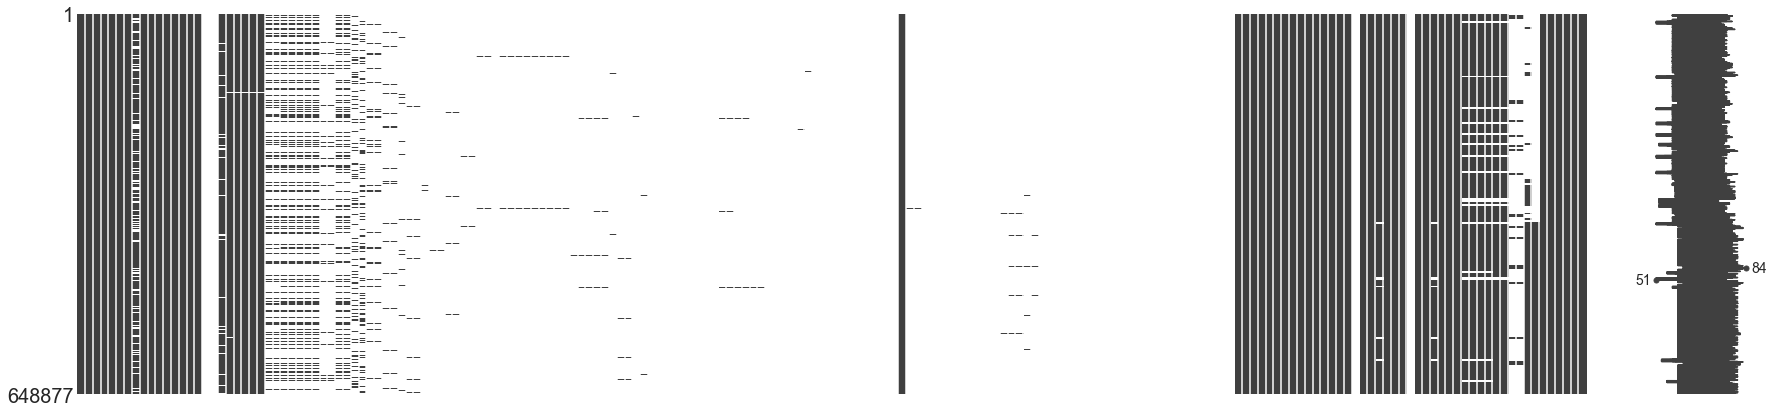

In [18]:
# Plot visualisation of the missing values for each feature of the raw DataFrame, df_sb_raw
msno.matrix(df_sb_raw, figsize = (30, 7))

In [19]:
# Counts of missing values
tm_null_value_stats = df_sb_raw.isnull().sum(axis=0)
tm_null_value_stats[tm_null_value_stats != 0]

duration                          159771
tactics.formation                 648144
tactics.lineup                    648144
related_events                     31709
location                            4425
                                   ...  
referee.name                       42734
referee.country.id                588148
referee.country.name              588148
metadata.shot_fidelity_version    290028
metadata.xy_fidelity_version      356613
Length: 146, dtype: int64

The visualisation shows us very quickly that many of the fields have missing values for the events columns, but this is normal for the dataset.

---

## <a id='#section4'>4. Data Engineering</a>

### <a id='#section4.1'>4.1. Assign Raw DataFrame to Engineered DataFrame</a>

In [20]:
# Assign Raw DataFrame to Engineered DataFrame
df_sb = df_sb_raw

### <a id='#section4.2'>4.2. Break down `location` attributes into seperate attribute for X, Y (and sometimes Z) coordinates</a>

In [21]:
# Display all location columns
for col in df_sb.columns:
    if 'location' in col:
        print(col)

location
pass.end_location
carry.end_location
shot.end_location
goalkeeper.end_location


There are the following five 'location' attributes:
- `location`
- `pass.end_location`
- `carry.end_location`
- `shot.end_location`
- `goalkeeper.end_location`

From reviewing the official documentation [[link](https://statsbomb.com/stat-definitions/)], the five attributes have the following dimensionality:
- `location` [x, y, z]
- `pass.end_location` [x, y]
- `carry.end_location` [x, y]
- `shot.end_location` [x, y, z]
- `goalkeeper.end_location` [x, y]

In [26]:
df_sb.head(5)

,id,index,period,timestamp,minute,second,possession,duration,type.id,type.name,possession_team.id,possession_team.name,play_pattern.id,play_pattern.name,team.id,team.name,tactics.formation,tactics.lineup,related_events,location,player.id,player.name,position.id,position.name,pass.recipient.id,pass.recipient.name,pass.length,pass.angle,pass.height.id,pass.height.name,pass.end_location,pass.type.id,pass.type.name,pass.body_part.id,pass.body_part.name,carry.end_location,under_pressure,pass.outcome.id,pass.outcome.name,ball_receipt.outcome.id,ball_receipt.outcome.name,counterpress,duel.type.id,duel.type.name,pass.aerial_won,interception.outcome.id,interception.outcome.name,dribble.outcome.id,dribble.outcome.name,pass.assisted_shot_id,pass.shot_assist,shot.statsbomb_xg,shot.end_location,shot.key_pass_id,shot.body_part.id,shot.body_part.name,shot.type.id,shot.type.name,shot.outcome.id,shot.outcome.name,shot.technique.id,shot.technique.name,shot.freeze_frame,goalkeeper.end_location,goalkeeper.position.id,goalkeeper.position.name,goalkeeper.type.id,goalkeeper.type.name,off_camera,duel.outcome.id,duel.outcome.name,pass.switch,ball_recovery.recovery_failure,50_50.outcome.id,50_50.outcome.name,foul_committed.card.id,foul_committed.card.name,shot.one_on_one,shot.aerial_won,pass.through_ball,pass.technique.id,pass.technique.name,goalkeeper.outcome.id,goalkeeper.outcome.name,goalkeeper.technique.id,goalkeeper.technique.name,goalkeeper.body_part.id,goalkeeper.body_part.name,substitution.outcome.id,substitution.outcome.name,substitution.replacement.id,substitution.replacement.name,foul_won.defensive,clearance.aerial_won,pass.backheel,pass.cross,foul_committed.offensive,foul_committed.advantage,foul_won.advantage,dribble.overrun,foul_committed.penalty,foul_won.penalty,injury_stoppage.in_chain,miscontrol.aerial_won,block.offensive,match_id,shot.open_goal,shot.first_time,dribble.nutmeg,pass.cut_back,pass.deflected,pass.goal_assist,foul_committed.type.id,foul_committed.type.name,pass.miscommunication,ball_recovery.offensive,block.save_block,block.deflection,clearance.head,clearance.body_part.id,clearance.body_part.name,out,clearance.left_foot,clearance.right_foot,pass.inswinging,pass.straight,clearance.other,pass.outswinging,shot.redirect,shot.deflected,bad_behaviour.card.id,bad_behaviour.card.name,pass.no_touch,dribble.no_touch,shot.saved_off_target,goalkeeper.shot_saved_off_target,goalkeeper.lost_out,goalkeeper.punched_out,player_off.permanent,shot.saved_to_post,goalkeeper.shot_saved_to_post,goalkeeper.lost_in_play,goalkeeper.success_out,shot.follows_dribble,half_start.late_video_start,goalkeeper.success_in_play,half_end.early_video_end,goalkeeper.saved_to_post,match_date,kick_off,home_score,away_score,match_status,last_updated,match_week,competition.competition_id,competition.country_name,competition.competition_name,season.season_id,season.season_name,home_team.home_team_id,home_team.home_team_name,home_team.home_team_gender,home_team.home_team_group,home_team.country.id,home_team.country.name,home_team.managers,away_team.away_team_id,away_team.away_team_name,away_team.away_team_gender,away_team.away_team_group,away_team.country.id,away_team.country.name,away_team.managers,metadata.data_version,competition_stage.id,competition_stage.name,stadium.id,stadium.name,stadium.country.id,stadium.country.name,referee.id,referee.name,referee.country.id,referee.country.name,metadata.shot_fidelity_version,metadata.xy_fidelity_version,competition_id,season_id,country_name,competition_name,competition_gender,season_name
0,1c6261d9-f0ae-4430-a087-30b4d1ef6e12,1,1,00:00:00.000,0,0,1,0.000000,35,Starting XI,969,Birmingham City WFC,1,Regular Play,969,Birmingham City WFC,4231.0,"[{'player': {'id': 15560, 'name': 'Ann-Katrin ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [59]:
#

##
#df_sb['location'] = df_sb['location'].astype(str)
#df_sb['pass.end_location'] = df_sb['pass.end_location'].astype(str)
#df_sb['carry.end_location'] = df_sb['carry.end_location'].astype(str)
#df_sb['shot.end_location'] = df_sb['shot.end_location'].astype(str)
#df_sb['goalkeeper.end_location'] = df_sb['goalkeeper.end_location'].astype(str)

##

###
df_sb['location'] = df_sb['location'].str.replace('[','')
df_sb['pass.end_location'] = df_sb['pass.end_location'].str.replace('[','')
df_sb['carry.end_location'] = df_sb['carry.end_location'].str.replace('[','')
df_sb['shot.end_location'] = df_sb['shot.end_location'].str.replace('[','')
df_sb['goalkeeper.end_location'] = df_sb['goalkeeper.end_location'].str.replace('[','')

###
df_sb['location'] = df_sb['location'].str.replace(']','')
df_sb['pass.end_location'] = df_sb['pass.end_location'].str.replace(']','')
df_sb['carry.end_location'] = df_sb['carry.end_location'].str.replace(']','')
df_sb['shot.end_location'] = df_sb['shot.end_location'].str.replace(']','')
df_sb['goalkeeper.end_location'] = df_sb['goalkeeper.end_location'].str.replace(']','')

##
df_sb[['location_x', 'location_y']] = df_sb['location'].str.split(", ",expand=True,)
df_sb[['pass.end_location_x', 'pass.end_location_y']] = df_sb['pass.end_location'].str.split(", ",expand=True,)
df_sb[['carry.end_location_x', 'carry.end_location_y']] = df_sb['carry.end_location'].str.split(", ",expand=True,)
df_sb[['shot.end_location_x', 'shot.end_location_y', 'shot.end_location_z']] = df_sb['shot.end_location'].str.split(", ",expand=True,)
df_sb[['goalkeeper.end_location_x', 'goalkeeper.end_location_y']] = df_sb['goalkeeper.end_location'].str.split(", ",expand=True,)

## Display DataFrame
df_sb.head()

,id,index,period,timestamp,minute,second,possession,duration,type.id,type.name,possession_team.id,possession_team.name,play_pattern.id,play_pattern.name,team.id,team.name,tactics.formation,tactics.lineup,related_events,location,player.id,player.name,position.id,position.name,pass.recipient.id,pass.recipient.name,pass.length,pass.angle,pass.height.id,pass.height.name,pass.end_location,pass.type.id,pass.type.name,pass.body_part.id,pass.body_part.name,carry.end_location,under_pressure,pass.outcome.id,pass.outcome.name,ball_receipt.outcome.id,ball_receipt.outcome.name,counterpress,duel.type.id,duel.type.name,pass.aerial_won,interception.outcome.id,interception.outcome.name,dribble.outcome.id,dribble.outcome.name,pass.assisted_shot_id,pass.shot_assist,shot.statsbomb_xg,shot.end_location,shot.key_pass_id,shot.body_part.id,shot.body_part.name,shot.type.id,shot.type.name,shot.outcome.id,shot.outcome.name,shot.technique.id,shot.technique.name,shot.freeze_frame,goalkeeper.end_location,goalkeeper.position.id,goalkeeper.position.name,goalkeeper.type.id,goalkeeper.type.name,off_camera,duel.outcome.id,duel.outcome.name,pass.switch,ball_recovery.recovery_failure,50_50.outcome.id,50_50.outcome.name,foul_committed.card.id,foul_committed.card.name,shot.one_on_one,shot.aerial_won,pass.through_ball,pass.technique.id,pass.technique.name,goalkeeper.outcome.id,goalkeeper.outcome.name,goalkeeper.technique.id,goalkeeper.technique.name,goalkeeper.body_part.id,goalkeeper.body_part.name,substitution.outcome.id,substitution.outcome.name,substitution.replacement.id,substitution.replacement.name,foul_won.defensive,clearance.aerial_won,pass.backheel,pass.cross,foul_committed.offensive,foul_committed.advantage,foul_won.advantage,dribble.overrun,foul_committed.penalty,foul_won.penalty,injury_stoppage.in_chain,miscontrol.aerial_won,block.offensive,match_id,shot.open_goal,shot.first_time,dribble.nutmeg,pass.cut_back,pass.deflected,pass.goal_assist,foul_committed.type.id,foul_committed.type.name,pass.miscommunication,ball_recovery.offensive,block.save_block,block.deflection,clearance.head,clearance.body_part.id,clearance.body_part.name,out,clearance.left_foot,clearance.right_foot,pass.inswinging,pass.straight,clearance.other,pass.outswinging,shot.redirect,shot.deflected,bad_behaviour.card.id,bad_behaviour.card.name,pass.no_touch,dribble.no_touch,shot.saved_off_target,goalkeeper.shot_saved_off_target,goalkeeper.lost_out,goalkeeper.punched_out,player_off.permanent,shot.saved_to_post,goalkeeper.shot_saved_to_post,goalkeeper.lost_in_play,goalkeeper.success_out,shot.follows_dribble,half_start.late_video_start,goalkeeper.success_in_play,half_end.early_video_end,goalkeeper.saved_to_post,match_date,kick_off,home_score,away_score,match_status,last_updated,match_week,competition.competition_id,competition.country_name,competition.competition_name,season.season_id,season.season_name,home_team.home_team_id,home_team.home_team_name,home_team.home_team_gender,home_team.home_team_group,home_team.country.id,home_team.country.name,home_team.managers,away_team.away_team_id,away_team.away_team_name,away_team.away_team_gender,away_team.away_team_group,away_team.country.id,away_team.country.name,away_team.managers,metadata.data_version,competition_stage.id,competition_stage.name,stadium.id,stadium.name,stadium.country.id,stadium.country.name,referee.id,referee.name,referee.country.id,referee.country.name,metadata.shot_fidelity_version,metadata.xy_fidelity_version,competition_id,season_id,country_name,competition_name,competition_gender,season_name,location_x,location_y,pass.end_location_x,pass.end_location_y,carry.end_location_x,carry.end_location_y,shot.end_location_x,shot.end_location_y,shot.end_location_z,goalkeeper.end_location_x,goalkeeper.end_location_y
0,1c6261d9-f0ae-4430-a087-30b4d1ef6e12,1,1,00:00:00.000,0,0,1,0.000000,35,Starting XI,969,Birmingham City WFC,1,Regular Play,969,Birmingham City WFC,4231.0,"[{'player': {'id': 15560, 'name': 'Ann-Katrin ...",NaN,NaN,NaN,NaN,NaN,

### <a id='#section4.3'>4.3. Extract Lineups from DataFrame</a>

In [60]:
# List unique values in the df_sb['type.name'] column
df_sb['type.name'].unique()

array(['Starting XI', 'Half Start', 'Pass', 'Ball Receipt*', 'Carry',
       'Pressure', 'Ball Recovery', 'Block', 'Duel', 'Interception',
       'Dribbled Past', 'Dribble', 'Shot', 'Goal Keeper',
       'Foul Committed', 'Foul Won', 'Dispossessed', 'Clearance',
       'Miscontrol', '50/50', 'Injury Stoppage', 'Player Off',
       'Player On', 'Substitution', 'Shield', 'Tactical Shift',
       'Half End', 'Error', 'Referee Ball-Drop', 'Offside',
       'Own Goal Against', 'Own Goal For', 'Bad Behaviour'], dtype=object)

The starting XI players and formation can be found in the rows where `type.name` is 'Starting XI'.

In [61]:
df_lineup = df_sb[df_sb['type.name'] == 'Starting XI']

In [62]:
df_lineup

,id,index,period,timestamp,minute,second,possession,duration,type.id,type.name,possession_team.id,possession_team.name,play_pattern.id,play_pattern.name,team.id,team.name,tactics.formation,tactics.lineup,related_events,location,player.id,player.name,position.id,position.name,pass.recipient.id,pass.recipient.name,pass.length,pass.angle,pass.height.id,pass.height.name,pass.end_location,pass.type.id,pass.type.name,pass.body_part.id,pass.body_part.name,carry.end_location,under_pressure,pass.outcome.id,pass.outcome.name,ball_receipt.outcome.id,ball_receipt.outcome.name,counterpress,duel.type.id,duel.type.name,pass.aerial_won,interception.outcome.id,interception.outcome.name,dribble.outcome.id,dribble.outcome.name,pass.assisted_shot_id,pass.shot_assist,shot.statsbomb_xg,shot.end_location,shot.key_pass_id,shot.body_part.id,shot.body_part.name,shot.type.id,shot.type.name,shot.outcome.id,shot.outcome.name,shot.technique.id,shot.technique.name,shot.freeze_frame,goalkeeper.end_location,goalkeeper.position.id,goalkeeper.position.name,goalkeeper.type.id,goalkeeper.type.name,off_camera,duel.outcome.id,duel.outcome.name,pass.switch,ball_recovery.recovery_failure,50_50.outcome.id,50_50.outcome.name,foul_committed.card.id,foul_committed.card.name,shot.one_on_one,shot.aerial_won,pass.through_ball,pass.technique.id,pass.technique.name,goalkeeper.outcome.id,goalkeeper.outcome.name,goalkeeper.technique.id,goalkeeper.technique.name,goalkeeper.body_part.id,goalkeeper.body_part.name,substitution.outcome.id,substitution.outcome.name,substitution.replacement.id,substitution.replacement.name,foul_won.defensive,clearance.aerial_won,pass.backheel,pass.cross,foul_committed.offensive,foul_committed.advantage,foul_won.advantage,dribble.overrun,foul_committed.penalty,foul_won.penalty,injury_stoppage.in_chain,miscontrol.aerial_won,block.offensive,match_id,shot.open_goal,shot.first_time,dribble.nutmeg,pass.cut_back,pass.deflected,pass.goal_assist,foul_committed.type.id,foul_committed.type.name,pass.miscommunication,ball_recovery.offensive,block.save_block,block.deflection,clearance.head,clearance.body_part.id,clearance.body_part.name,out,clearance.left_foot,clearance.right_foot,pass.inswinging,pass.straight,clearance.other,pass.outswinging,shot.redirect,shot.deflected,bad_behaviour.card.id,bad_behaviour.card.name,pass.no_touch,dribble.no_touch,shot.saved_off_target,goalkeeper.shot_saved_off_target,goalkeeper.lost_out,goalkeeper.punched_out,player_off.permanent,shot.saved_to_post,goalkeeper.shot_saved_to_post,goalkeeper.lost_in_play,goalkeeper.success_out,shot.follows_dribble,half_start.late_video_start,goalkeeper.success_in_play,half_end.early_video_end,goalkeeper.saved_to_post,match_date,kick_off,home_score,away_score,match_status,last_updated,match_week,competition.competition_id,competition.country_name,competition.competition_name,season.season_id,season.season_name,home_team.home_team_id,home_team.home_team_name,home_team.home_team_gender,home_team.home_team_group,home_team.country.id,home_team.country.name,home_team.managers,away_team.away_team_id,away_team.away_team_name,away_team.away_team_gender,away_team.away_team_group,away_team.country.id,away_team.country.name,away_team.managers,metadata.data_version,competition_stage.id,competition_stage.name,stadium.id,stadium.name,stadium.country.id,stadium.country.name,referee.id,referee.name,referee.country.id,referee.country.name,metadata.shot_fidelity_version,metadata.xy_fidelity_version,competition_id,season_id,country_name,competition_name,competition_gender,season_name,location_x,location_y,pass.end_location_x,pass.end_location_y,carry.end_location_x,carry.end_location_y,shot.end_location_x,shot.end_location_y,shot.end_location_z,goalkeeper.end_location_x,goalkeeper.end_location_y
0,1c6261d9-f0ae-4430-a087-30b4d1ef6e12,1,1,00:00:00.000,0,0,1,0.0,35,Starting XI,969,Birmingham City WFC,1,Regular Play,969,Birmingham City WFC,4231.0,"[{'player': {'id': 15560, 'name': 'Ann-Katrin ...",NaN,NaN,NaN,NaN,NaN,NaN,N

In [63]:
# Streamline DataFrame to include just the columns of interest

## Define columns
cols = ['id', 'type.name', 'team.id', 'team.name', 'tactics.formation', 'tactics.lineup']

## Select only columns of interest
df_lineup_select = df_lineup[cols]

In [64]:
df_lineup_select

,id,type.name,team.id,team.name,tactics.formation,tactics.lineup
0,1c6261d9-f0ae-4430-a087-30b4d1ef6e12,Starting XI,969,Birmingham City WFC,4231.0,"[{'player': {'id': 15560, 'name': 'Ann-Katrin ..."
1,489dd844-2b2e-4b0c-90ef-7bbab5ab4bd7,Starting XI,971,Chelsea FCW,42211.0,"[{'player': {'id': 4640, 'name': 'Rut Hedvig L..."
3527,58bb5658-80a5-4b17-86a0-20111ab91353,Starting XI,972,West Ham United LFC,442.0,"[{'player': {'id': 18158, 'name': 'Rebecca Lei..."
3528,bbad0c35-aef8-40bf-b213-226e86c5f2f7,Starting XI,966,Liverpool WFC,4321.0,"[{'player': {'id': 19778, 'name': 'Frances Kit..."
6565,04c3b8ac-d7a9-490e-a167-334fb353c82a,Starting XI,974,Reading WFC,4222.0,"[{'player': {'id': 15719, 'name': 'Grace Molon..."
...,...,...,...,...,...,...
638307,36de8f79-c32a-4163-8ad7-bf2da3db4f9e,Starting XI,749,Tottenham Hotspur Women,442.0,"[{'player': {'id': 33349, 'name': 'Chloe Morga..."
641636,32898ea7-108b-4f9b-86ec-847f35aa2974,Starting XI,966,Liverpool WFC,4231.0,"[{'player': {'id': 15626, 'name': 'Anke Preuß'..."
641637,33bbf774-d931-4e8e-bbaa-6ba618878f25,Starting XI,967,Everton LFC,433.0,"[{'player': {'id': 13857, 'name': 'Tinja-Riikk..."
645124,d7b811ef-4156-4e3c-a357-aed72b7c53b7,Starting XI,971,Chelsea FCW,442.0,"[{'player': {'id': 19421, 'name': 'Carly Mitch..."


We can see from the extracted lineup data so far. To get the stating XI players, we need to breakdown the `tactics.lineup` attribute.

In [70]:
df = df_lineup_select

In [71]:
# explode all columns with lists of dicts
df = df.apply(lambda x: x.explode()).reset_index(drop=True)

# list of columns with dicts
cols_to_normalize = ['tactics.lineup']

# if there are keys, which will become column names, overlap with excising column names
# add the current column name as a prefix
normalized = list()
for col in cols_to_normalize:
    
    d = pd.json_normalize(df[col], sep='_')
    d.columns = [f'{col}_{v}' for v in d.columns]
    normalized.append(d.copy())

# combine df with the normalized columns
df = pd.concat([df] + normalized, axis=1).drop(columns=cols_to_normalize)

display(df)

AttributeError: 'str' object has no attribute 'values'

In [65]:
# Normalize tactics.lineup - see: https://stackoverflow.com/questions/52795561/flattening-nested-json-in-pandas-data-frame

## explode all columns with lists of dicts
df_lineup_select_normalize = df_lineup_select.apply(lambda x: x.explode()).reset_index(drop=True)

## list of columns with dicts
cols_to_normalize = ['tactics.lineup']

## if there are keys, which will become column names, overlap with excising column names. add the current column name as a prefix
normalized = list()

for col in cols_to_normalize:
    d = pd.json_normalize(df_lineup_select_normalize[col], sep='_')
    d.columns = [f'{col}_{v}' for v in d.columns]
    normalized.append(d.copy())

## combine df with the normalized columns
df_lineup_select_normalize = pd.concat([df_lineup_select_normalize] + normalized, axis=1).drop(columns=cols_to_normalize)

## display(df_lineup_select_normalize)
df_lineup_select_normalize.head(10)

AttributeError: 'str' object has no attribute 'values'

### <a id='#section4.4'>4.4. Tactical Shifts</a>

In [ ]:
df_tactics = df_sb[df_sb['type.name'] == 'Tactical Shift']

In [ ]:
df_tactics

In [ ]:
# Select columns of interest

##
cols = ['id', 'type.name', 'team.id', 'team.name', 'tactics.formation', 'tactics.lineup']

##
df_tactics_select = df_tactics[cols]

In [ ]:
df_tactics_select

In [ ]:
# Normalize tactics.lineup - see: https://stackoverflow.com/questions/52795561/flattening-nested-json-in-pandas-data-frame

## explode all columns with lists of dicts
df_tactics_select_normalize = df_tactics_select.apply(lambda x: x.explode()).reset_index(drop=True)

## list of columns with dicts
cols_to_normalize = ['tactics.lineup']

## if there are keys, which will become column names, overlap with excising column names. add the current column name as a prefix
normalized = list()
for col in cols_to_normalize:
    
    d = pd.json_normalize(df_tactics_select_normalize[col], sep='_')
    d.columns = [f'{col}_{v}' for v in d.columns]
    normalized.append(d.copy())

## combine df with the normalized columns
df_tactics_select_normalize = pd.concat([df_tactics_select_normalize] + normalized, axis=1).drop(columns=cols_to_normalize)

## display(df_lineup_select_normalize)
df_tactics_select_normalize.head(10)

### <a id='#section4.5'>4.5. Halves</a>

In [ ]:
df_half = df_sb[df_sb['type.name'] == 'Half Start']

In [ ]:
df_half

### <a id='#section4.6'>4.6. Extract a DataFrame only of In-Play Events</a>
DataFrame of only player's actions i.e. removing line ups, halves, etc.

In [ ]:
# List unique values in the df_sb['type.name'] column
df_sb['type.name'].unique()

In [ ]:
lst_events = ['Pass', 'Ball Receipt*', 'Carry', 'Duel', 'Miscontrol', 'Pressure', 'Ball Recovery', 'Dribbled Past', 'Dribble', 'Shot', 'Block', 'Goal Keeper', 'Clearance', 'Dispossessed', 'Foul Committed', 'Foul Won', 'Interception', 'Shield', 'Half End', 'Substitution', 'Tactical Shift', 'Injury Stoppage', 'Player Off', 'Player On', 'Offside', 'Referee Ball-Drop', 'Error']

In [ ]:
df_events = df_sb[df_sb['type.name'].isin(lst_events)]

In [ ]:
df_events

In [ ]:
df_events.shape

#### <a id='#section4.6.1'>4.6.1. Goals</a>

In [ ]:
df_shots = df_events[df_events['type.name'] == 'Shot']

In [ ]:
df_shots

In [ ]:
df_goals = df_shots[df_shots['shot.outcome.name'] == 'Goal']

In [ ]:
df_goals

### <a id='#section4.7'>4.7. Export DataFrame</a>
Export the engineered Events, Lineup, and Tactics [StatsBomb](https://statsbomb.com/) DataFrames as CSV files.

##### Break down data into individual matches

In [28]:
# Export the engineered DataFrames
#df_lineup_combined.to_csv(data_dir_sb + '/engineered/lineup_reading_stoke_07112020.csv', index=None, header=True)
#df_tactics_combined.to_csv(data_dir_sb + '/engineered/tactics_reading_stoke_07112020.csv', index=None, header=True)
#df_events.to_csv(data_dir_sb + '/engineered/events_reading_stoke_07112020.csv', index=None, header=True)

### <a id='#section4.8'>4.8. Aggregate Data</a>

#### <a id='#section4.8.1'>4.8.1. Fixture Level</a>

In [ ]:
# CODE HERE

#### <a id='#section4.8.2'>4.8.2. Team Level</a>

In [ ]:
# CODE HERE

Now we have created three pandas DataFrames and wrangled the data to meet our needs, we'll next conduct and [Exploratory Data Analysis ](#section5).

---

## <a id='#section5'>5. Exploratory Data Analysis</a>

### <a id='#section5.1'>5.1. Shot Maps</a>

#### <a id='#section5.1.1'>5.1.1. X,Y Conversion and Pitch Measurements</a>
Convert StatBombs's coordinates from 0,100 to a range of x(0,104) and y(0,68) - the average pitch size.

If you have access to the data and know the exact dimensions for pitches in the leagues you are interested in, you could make this even more accurate.

In [ ]:
sb_pitch_length_x =120
sb_pitch_length_y = 80

pitch_length_x = 104
pitch_length_y = 68

In [ ]:
# Add new columns

## Convert StatsBomb coordinates from 0,100 to a range of x(0,104) and y(0,68) - the average pitch size.
df_events['shot.end_location_xM'] = (df_events['shot.end_location_x'] / sb_pitch_length_x) * pitch_length_x
df_events['shot.end_location_yM'] = (df_events['shot.end_location_y'] / sb_pitch_length_y) * pitch_length_y

## Create reverse columns of previous created 'XM' and 'YM' columns
df_events['shot.end_location_xM_r'] = pitch_length_x - df_events['shot.end_location_xM']    # Added for completeness but not used
df_events['shot.end_location_yM_r'] = pitch_length_y - df_events['shot.end_location_yM']

## Create column of scaled xG to make them larger in the plot
df_events['shot.statsbomb_xg_s'] = df_events['shot.statsbomb_xg'] * 1.5

In [ ]:
df_events

#### <a id='#section5.1.2'>5.1.2. Plot Shots</a>

In [ ]:
# Plotting Shots

## Define DataFrame
df_shots = df_events[df_events['possession_team.name'] == 'Stoke City']

## Draw the pitch
draw_pitch("#195905","#faf0e6","vertical","half")

## Define zo
zo = 12

## X and Y coordinates
x = df_shots['shot.end_location_xM'].tolist()
y = df_shots['shot.end_location_yM'].tolist()
y1 = [68 - i for i in y]


## Add Z variable for xG
z = df_shots['shot.statsbomb_xg_s'].tolist()
z1 = [500 * i for i in z] # This is to scale the "xG" values for plotting


## Add small legend in the bottom corner
mSize = [0.05,0.10,0.2,0.4,0.6,1]
mSizeS = [500 * i for i in mSize]
mx = [5.5,7,9,11,13.5,16.5]
my = [60,60,60,60,60,60]

plt.text(11,55,"xG", color="white", ha="center",va="center", zorder=zo, fontsize=16)
plt.scatter(y1,x,s=z1, c="red",edgecolors="k",zorder=zo)
plt.scatter(mx,my,s=mSizeS,facecolors="white", edgecolor="white",zorder=zo)
plt.plot([5.5,17], [57,57],color="white",lw=2,zorder=zo)

i = 0

for i in range(len(mx)):
    plt.text(mx[i], my[i], mSize[i], fontsize=mSize[i]*18, color="#195905", zorder=zo,ha="center", va="center")

    
## Title
plt.title('Reading 0 vs. 3 Stoke City (07/11/2020)')

## Show plot
plt.show()

### <a id='#section5.2'>5.2. Aggregation of Event Data for Stats</a>

In [ ]:
# Create stats aggregated table like that seen in on FBref here

---

## <a id='#section6'>6. Summary</a>
This notebook engineers scraped [StatsBomb](https://statsbomb.com/) data using [pandas](http://pandas.pydata.org/).

---

## <a id='#section7'>7. Next Steps</a>
...

---

## <a id='#section8'>8. References</a>

#### Data
*    [StatsBomb](https://statsbomb.com/) data
*    [StatsBomb](https://github.com/statsbomb/open-data/tree/master/data) open data GitHub repository

---

***Visit my website [EddWebster.com](https://www.eddwebster.com) or my [GitHub Repository](https://github.com/eddwebster) for more projects. If you'd like to get in contact, my Twitter handle is [@eddwebster](http://www.twitter.com/eddwebster) and my email is: edd.j.webster@gmail.com.***

[Back to the top](#top)